# Lab3.4 Sentiment Analysis with machine-learning

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

The focus of this notebook is on performing sentiment analysis using the scikit-learn package. Material from [this notebook](http://www.pitt.edu/~naraehan/presentation/Movie+Reviews+sentiment+analysis+with+Scikit-Learn.html) was re-used and adapted.

**At the end of this notebook, you will be able to**:
* load the training data, i.e., the movie reviews
* inspect the training data, i.e., the movie reviews
* extracting features from the training data
* training and evaluating the *NaiveBayesClassifier*
* apply the classifier to movie reviews


For training a machine learning system we need a number of packages, the most important ones are *sklearn* and *numpy* to manipulate data and call machine learning functions. Since we are dealing with texts, we also need some specific packages from *sklearn* to operate on texts to get words as features.

In [5]:
import sklearn
import numpy
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## Loading a dataset
We are first going to load and inspect the **airlinetweets** dataset (which is included in the data folder that you downloaded from the HLT course Github). This data set originates from:

https://www.kaggle.com/crowdflower/twitter-airline-sentiment

Kaggle is a platform where you can find many more data sets.

We are going to use the method **load_files** as part of sklearn and which we imported above. Let's first inspect what the help message of the function **load_files** states.

In [6]:
help(load_files)

Help on function load_files in module sklearn.datasets._base:

load_files(container_path, *, description=None, categories=None, load_content=True, shuffle=True, encoding=None, decode_error='strict', random_state=0, allowed_extensions=None)
    Load text files with categories as subfolder names.
    
    Individual samples are assumed to be files stored a two levels folder
    structure such as the following:
    
        container_folder/
            category_1_folder/
                file_1.txt
                file_2.txt
                ...
                file_42.txt
            category_2_folder/
                file_43.txt
                file_44.txt
                ...
    
    The folder names are used as supervised signal label names. The individual
    file names are not important.
    
    This function does not try to extract features into a numpy array or scipy
    sparse matrix. In addition, if load_content is false it does not try to
    load the files in memory.
    
    

Ok, so the function requires the following structure of the data on your disk in order for it to work:

* container_folder/
    * category_1_folder/ (e.g., 'positive')
        * file_1.txt
        * file_2.txt
        * ...
        * file_42.txt
    * category_2_folder/ (e.g., 'negative')
        * file_43.txt
        * file_44.txt
        * ...
        
The names of the subfolders are treated as the labels for the data and you are supposed to divided the text files over the subfolders accordingly.

Let's check whether our **airlinetweets** corpus has this structure. In the data folder, you will see a folder "airlinetweets" with 3 subfolders: "negative", "neutral", and "positive". These subfolder names will represent our sentiment labels. In each folder, you find a long list of text files, each containing a tweet. This is our training and test data per category.

We will use the **pathlib** package to get the path of this notebook and extend it with "data/airlinetweets", assuming that you stored the data in this location. If this is not the case, you need to adapt the path accordingly.

In [7]:
import pathlib
cwd = pathlib.Path.cwd()
airline_tweets_folder = cwd.joinpath('data/airlinetweets')
print('path:', airline_tweets_folder)
print('this will print True if the folder exists:', 
      airline_tweets_folder.exists())

path: /Users/piek/Desktop/t-MA-HLT-introduction-2023/ma-hlt-labs/lab3.machine_learning/data/airlinetweets
this will print True if the folder exists: True


In [8]:
str(airline_tweets_folder)

'/Users/piek/Desktop/t-MA-HLT-introduction-2023/ma-hlt-labs/lab3.machine_learning/data/airlinetweets'

Inspect on your local machine whether the data has the required structure. Take your time to open files and inspect them. It is always good to know what forms your data.

....

....

Hopefully, it is! Let's now load it using the **load_files** function.

In [9]:
# loading all files as training data.
airline_tweets_train = load_files(str(airline_tweets_folder))

## Inspecting the dataset

The load_files function will read each file separately and store it as a data item or instance. The data is internally stored as a specfic type of object called *Bunch*, which consists of a description 'DESCR', the names of the loaded files, the target data and the category labels (target_names).

In [10]:
print(type(airline_tweets_train))
print(dir(airline_tweets_train))
print(type(airline_tweets_train.target))
print('Target names', airline_tweets_train.target_names)

<class 'sklearn.utils._bunch.Bunch'>
['DESCR', 'data', 'filenames', 'target', 'target_names']
<class 'numpy.ndarray'>
Target names ['negative', 'neutral', 'positive']


How many files do we have? Well, that would be the same as the number of data items.

In [11]:
print('Number of data items created from the loaded files', len(airline_tweets_train.data))

Number of data items created from the loaded files 4755


If you do not like the data labels, you could change the names of the subdirectories. If you do not agree with the distinctions, you could add other folders with other category names and move files to these folders.

Note that *target* is a **numpy.ndarray** which stands for numeric data array. Here it represents the index to the category values for all the data that we loaded, in this case all the tweet files: 4,755 in total. The category values are represented in a list of target_names so the value '0' represents 'negative', '1' represents 'neutral' and '2' represents 'positive'. Let's have a look. Because it is a *numpy* object, we need to convert it to a list to print it.

In [13]:
print(len(airline_tweets_train.target.tolist()))
#Print the first ten items in the list
print(airline_tweets_train.target.tolist()[:10])

4755
[1, 1, 2, 1, 0, 0, 1, 1, 0, 1]


In this case, the numbers are not the vector representations of the words but the numerical representation of the categories.

We see a sequence of 0, 1, 2 values which represents the sequence of categories for the sequence of loaded texts. The first two are neutral (1) and the third is positive (2), the fifth negative (0).

Let's is look at the actual text instances. What is the first text, which is supposed to be neutral:

In [14]:
# Let's inspect the first data element
airline_tweets_train.data[0]

b'@AmericanAir Why is your cover photo of TWA? Just wondering.'

In [17]:
# which comes from the first file from "neutral" folder
airline_tweets_train.filenames[0]

'/Users/piek/Desktop/t-MA-HLT-introduction-2023/ma-hlt-labs/lab3.machine_learning/data/airlinetweets/neutral/AL_570069345818161152.txt'

In [18]:
# first file is a neutral review and is mapped to index 1 in target_names
airline_tweets_train.target[0]

1

We can find out what the index means by inserting it into **target_names**

In [19]:
airline_tweets_train.target_names[1]

'neutral'

How many do we have for each category? We can use the **Counter** package in Python to get statistics from the target structure by counting each category value and displaying the category using the index:

In [20]:
from collections import Counter

freqs = Counter(airline_tweets_train.target)
print(type(freqs))
## a Counter object conists of items which are pairs with an element and its count

for category, frequency in freqs.items():
    print(category, frequency)
    print(airline_tweets_train.target_names[category], frequency)

<class 'collections.Counter'>
1 1515
neutral 1515
2 1490
positive 1490
0 1750
negative 1750


We can see that the data are equally distributed over the three categories, which is good!

## Extracting features from training data


We now have loaded a data set as instances of the object <class 'sklearn.utils.Bunch'> in our notebook. Next, we are going to use the CountVectorizer function to process the text data and to create a **Bag-of-Words** presentation as we have done before for the toy data. We define a separate instance of CountVectorizer for each data set. 

In [21]:
# initialize airline object, and then turn airline tweets train data into a vector 

airline_vec = CountVectorizer(min_df=10, # If a token appears fewer times than this, across all documents, it will be ignored
                             tokenizer=nltk.word_tokenize, # we use the nltk tokenizer
                             stop_words=stopwords.words('english')) # stopwords are removed

In order to represent each document in terms of this vector, we use the *fit_transform* function to generate a matrix of documents (the rows) and the vectors with the scores for each word that occurs in each document. The *fit_transform* function creates the model from the vocabulary and applies some transformation to it. You can also use the *fit* function.

Note: you might get a warning when you run the following cell. You do NOT have to resolve the warning.

In [22]:
airline_counts = airline_vec.fit_transform(airline_tweets_train.data)

/Users/piek/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/piek/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


We have now created a vector representation *airline_vec* of the complete vocabulary of the full data set. Every position in this vector represents a unique word.

In [23]:
#Total number of word features or the length of the total vector
print('Total number of words in our data:', len(airline_vec.vocabulary_))

Total number of words in our data: 653


In [24]:
# First 50 feature names
print(list(airline_vec.get_feature_names_out())[:50])

['!', '#', '$', '&', "'", "''", "'d", "'ll", "'m", "'re", "'s", "'ve", '(', ')', '-', '--', '.', '..', '...', '....', '1', '10', '100', '15', '1k', '1st', '2', '20', '200', '2015', '24', '25', '2nd', '3', '30', '4', '40', '45', '5', '50', '6', '7', '8', ':', ';', '?', '@', '``', 'aa', 'able']


In [25]:
# 'plane' is found in the corpus, mapped to index 1948
airline_vec.vocabulary_.get('plane')

443

We can now inspect the dimensions of our feature array by getting the spape: the rows (documents) and columns (the word vector length).

In [26]:
# large dimensions! 4,755 documents, 2902 unique terms. 
airline_counts.shape

(4755, 653)

It is important to inspect the dimensions of the data matrix. We see that we have 4,755 text instances with each a vector array of 2,902 positions. Each position represents a word from the training data for which we can set a value that indicates if or how often it occurs in a text instance.

We can convert the matrix to an array and get the first element and look at the vector values for slots 100 till 200:

In [27]:
print(airline_counts.toarray()[0][100:200])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We can see that most values are zero's and just a few have the value 1. This is what we call a *sparse vector*.

As we have seen in the previous Lab, we can also transform the counts into information value scores using the *TfidfTransformer* function.

In [28]:
# Convert raw frequency counts into TF-IDF values
tfidf_transformer = TfidfTransformer()
airline_tfidf = tfidf_transformer.fit_transform(airline_counts)

Obviously the shape remains the same but the values are now weighted scores between zero and one.

In [29]:
# Same dimensions, now with tf-idf values instead of raw frequency counts
datarow = 30
print(airline_tfidf.shape)
# we print values 100:250 for datarow 
print(airline_tfidf.toarray()[datarow][10:250])

(4755, 653)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.33609914
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.26745264
 0.         0.28262499 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0520561  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.   

## Training and testing a Naive Bayes classifier for airline tweets

We can now use the above data representation as training data to build a classifier. the Sklearn package already associated each row (a document) in our data representation with a label by taking the name of the data subfolder.

In [30]:
print("Label for data at row:", airline_tweets_train.target[datarow])
print("Name for the label as number:", airline_tweets_train.target_names[airline_tweets_train.target[datarow]])

Label for data at row: 0
Name for the label as number: negative


We are going to use a simple Naive Bayes classifier to train a model. A Naive Bayes (NB) classifier is a so-called generative classifier that learns the probablity of a word given a category. By assessing the probability of words for a text, it can aggregate how likely a text is for a category. You will learn more about this type of classifier in the machine learning code. For now it is enough to know that NB works reasonably for smaller data sets and with little training.  

Because we have multiple labels (negative, positive, neutral) and therefore are dealing with 3 classes, we need a *multinomial classifier*.

In [31]:
# Now ready to build a classifier. 
# We will use Multinomial Naive Bayes as our model
from sklearn.naive_bayes import MultinomialNB

It is easy for machine learning package to read the above vector representations and to associate these with any type of label. However, we also want to test the data. For that purpose, we need to exclude part of the data from the training set.

To train the classifier, we will first split the data into train and test. Sklearn has a built in function for this that we need to import.

In [32]:
# Split data into training and test sets
# from sklearn.cross_validation import train_test_split  # deprecated in 0.18
from sklearn.model_selection import train_test_split

We choose 80% training and 20% test. The function returns 4 different data structures that we need to catch: the training texts, the test texts, the training labels and the test labels. In Python, we can assign these to four different variables in one command call. The *train_test_split* function requires as input the model, the data and the train-test proportional split.

In [33]:
docs_train, docs_test, human_labels_train, human_labels_test = train_test_split(
    airline_tfidf, # the tf-idf model
    airline_tweets_train.target, # the tweets and their labels
    test_size = 0.20 # we use 80% for training and 20% for development
    ) 

We now find our training texts in *docs_train* and our test texts in *docs_test*. The corresponding sequence of labels for training are in *human_labels_train*, and those for testing are in *human_labels_test*.

In [34]:
print("Training texts:", len(docs_train.toarray()))
print("Training labels:", len(human_labels_train))
print("Test texts:", len(docs_test.toarray()))
print("Test labels:", len(human_labels_test))

Training texts: 3804
Training labels: 3804
Test texts: 951
Test labels: 951


We see that we have an equal number of texts and labels for train and test. The values should be in the right order.

One training instance looks like this:

In [35]:
docs_train[55].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.24639873, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.25914133, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.29324386,
        0.        , 0.07033507, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

it's label is:

In [36]:
human_labels_train[55]

0

which we know is:

In [37]:
airline_tweets_train.target_names[human_labels_train[55]]

'negative'

The *fit* function of sklearn takes as input the training data and the labels.

In [38]:
# Train a Multimoda Naive Bayes classifier
airline_tweets_clf = MultinomialNB().fit(docs_train, human_labels_train)

After training the classifier, we can apply it to test data that is represented in the same way. For this we use the *predict* function.

In [39]:
# Predicting the Test set results, find macro recall
system_labels_pred = airline_tweets_clf.predict(docs_test)

We can now print each test tweet and get the corresponding prediction.

In [40]:
test_item = 20
#### we need to get the text from the original text data before we did the split.
#### Remember that the nTH item in an array has an index of n-1 because we start the index with zero.
#### Likewise, we take the length of the training data minus 1, to find the start of the test data.
data_index = len(docs_train.toarray())-1+test_item
print('Tweet number:', data_index)
print('The test tweet:', airline_tweets_train.data[data_index])
print('one test tweet representation:', docs_test[test_item-1].toarray().tolist())
print('gold label:', human_labels_test[test_item-1])
print('classifier predicted:', system_labels_pred[test_item-1])

Tweet number: 3823
The test tweet: b'"Bruh...real tweet from @JetBlue ""Our fleet\'s on fleek. http://t.co/dqny4aKTg9"""'
one test tweet representation: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5772847808256882, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1099524653803265, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5290505595387851, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

### Measuring the quality of the system output against the human labels

Sklearn provides functions to obtain the recall, precision and f-measure for the test set results. We can simply pass the human labels and the system labels as input and set a parameter how to aggregate the overall score. Separate functions are provided for the recall, precision and f-measure.

In [41]:
sklearn.metrics.recall_score(y_true=human_labels_test,
                             y_pred=system_labels_pred,
                             average='micro')

0.8180862250262881

The classification_report function gives the complete result:

In [42]:
from sklearn.metrics import classification_report
labels=["negative", "neutral", "positive"]

report = classification_report(human_labels_test, system_labels_pred, digits = 3, target_names = labels)
print(report)

              precision    recall  f1-score   support

    negative      0.825     0.886     0.855       352
     neutral      0.805     0.735     0.768       298
    positive      0.821     0.821     0.821       301

    accuracy                          0.818       951
   macro avg      0.817     0.814     0.815       951
weighted avg      0.818     0.818     0.817       951



Whenever you generate a report such as this, don't just stare at the overall performance such as *accuracy* but consider also the results per category and what the relation is between recall and precision. Ideally, recall and precision are balanced but if they deviate it is worth thinking about the causes. Some good causes are:

<ol>
<li>Not enough training data to capture all variation in the test data
<li>Biased training data that makes one category stronger than the other
<li>Too much ambiguity so that words as features have different interpretions in different contexts
<li>Over-fitting to the training data so that it learns features that do not generalise to the test data
<li>Many others....
</ol>

During this master programme, you will work with many different data sets and analyse the performance of classifiers. Analysing different data, experimenting with text representations, settings and machine learning algorithm is the best way to learn about possible causes and how to mitigate them.

Creating a confusion matrix is the first step in understanding the behaviour of the classifier. For this we use the function from sklearn and visualise it through *seaborn*.

In [43]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(human_labels_test, system_labels_pred)
print(matrix)

[[312  21  19]
 [ 44 219  35]
 [ 22  32 247]]


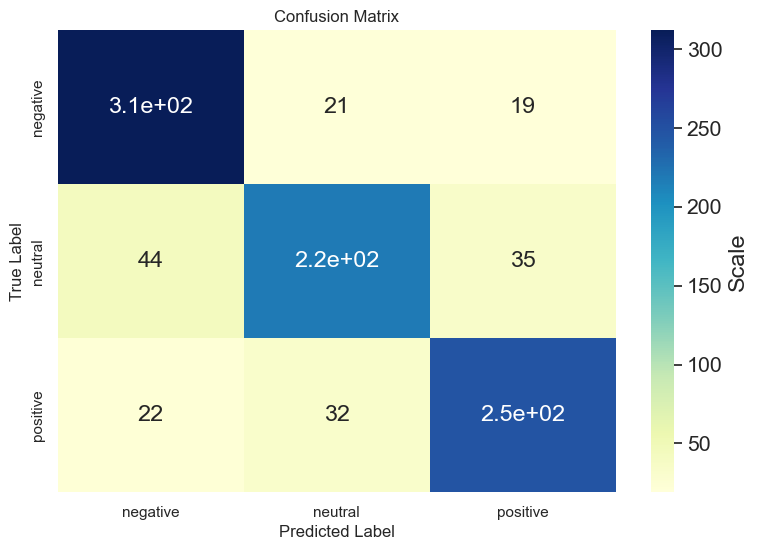

In [44]:
import seaborn
import matplotlib.pyplot as plt

 
def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix")
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")

    plt.show()
    plt.close()
    
plot_confusion_matrix(matrix, labels, "airline_tweet_confusion_matrix.png")

We can see here that by far most test cases are classifier correctly. There is some spill over to other categories but no significant differences. Most notably is the little confusion of "positive" with "negative" cases.

## Applying the airline tweets classifier on your own data
Now we can apply our classifier to new data. Let's type a few potential tweets.

In [45]:
# very short and fake movie reviews
my_reviews = ['This movie was excellent', 
               'Absolute joy ride', 
               'Steven Seagal was terrible', 
               'Steven Seagal shined through.', 
               'This was certainly a movie', 
               'Two thumbs up', 
               'I fell asleep halfway through', 
               "We can't wait for the sequel!!", 
               'I cannot recommend this highly enough', 
               'instant classic.', 
               'Steven Seagal was amazing.']
len(my_reviews)

11

To be able to apply our model to these texts, we need to represent the text using the same vector dimensions (columns!) as we used for training the model.

The sklearn transformer function does this work for you using the **transform** function. This function takes the vectors for representing the training data. Note that these vectors have a position for every word in the training data. So we cannot represent words that do not occur outside the training data, so-called Out-of-Vocabulary words. Technically, we do not need to worry because the **transform** function will take care of this but you can imagine that texts that are very different from the training data will be represented poorly by the model.

In [46]:
# We re-use airline_vec to transform it in the same way as the training data
my_review_counts = airline_vec.transform(my_reviews)
my_review_counts.shape

(11, 653)

We can see that the shape of our matrix represents 11 rows using the vectors with 2,902 dimensions that we created from the training data before. So words in our movie reviews that are NOT in the training data, are not represented as there are no slots in the vectors from the training data.

We can see this clearly, if we would use the **fit_transform** function instead of **transform** for our tweets, which will create a whole new model from our 11 tweets.

In [47]:
#### NEVER DO THE FOLLOWING
##bad_my_review_counts = airline_vec.fit_transform(my_reviews)
##bad_my_review_counts.shape

We see that we only have 4 dimensions left because the CountVectorizer created complete new vector representations using our settings: min_df=2,tokenizer=nltk.word_tokenize, stop_words=stopwords.words('english'). The vector only represents the words from my_reviews and this representation is incompatible with our trained model. So we cannot use this representation!!

This is a mistake you are likely to make. Remember:

1. build a vectore representation from the features from the training data: use **fit** or **fit_transform** with your defined CountVectorizer instance
2. train a classifier from these representation
3. always, always use the **transform** function from your defined CountVectorizer instance (which has been derived using the training data) to represent any other texts thatr you want to classify

It is good practice to always check the **shape** function if the texts are represented using the same number of dimensions.

Assuming that our own review texts are now propery represented in *my_review_counts*, we can proceed with calculating **TF\*IDF** values and use our trained classifier to make predictions on these representations.

In [48]:
# we compute tf idf values
my_reviews_tfidf = tfidf_transformer.transform(my_review_counts)

In [49]:
my_reviews_tfidf.shape

(11, 653)

These dimensions are correct so let's get the predictions:

In [50]:
# have classifier make a prediction
pred_on_my_reviews = airline_tweets_clf.predict(my_reviews_tfidf)

In [51]:
# print out results ()
for review, predicted_label in zip(my_reviews, pred_on_my_reviews):
    
    print('%s => %s' % (review, 
                        airline_tweets_train.target_names[predicted_label]))

This movie was excellent => positive
Absolute joy ride => negative
Steven Seagal was terrible => negative
Steven Seagal shined through. => negative
This was certainly a movie => negative
Two thumbs up => negative
I fell asleep halfway through => negative
We can't wait for the sequel!! => negative
I cannot recommend this highly enough => negative
instant classic. => negative
Steven Seagal was amazing. => positive


Take a minute to see if these reviews are correctly classified. What would be needed to evaluate the performance?

## Training another classifier with movie reviews

Through the **load_files** function, we can easily load any text collection per category by putting them into separate subfolders.  Let's try another one. Remember from the first Lab that some of the NLTK data is structured precisely in the same way as the airlinetweets data, e.g. nltk_data/corpora/movie_reviews.

Likewise, we can load this data in the same way using the load_files function. First adapt the path below to point to the location on your local laptop.

In [52]:
movie_reviews_folder = cwd.joinpath('/Users/piek/nltk_data/corpora/movie_reviews')
print('path:', movie_reviews_folder)
print('this will print True if the folder exists:', movie_reviews_folder.exists())

path: /Users/piek/nltk_data/corpora/movie_reviews
this will print True if the folder exists: True


In [53]:
movie_reviews_train = load_files(str(movie_reviews_folder))
print(type(movie_reviews_train))
print(dir(movie_reviews_train))
print('Number of data items', len(movie_reviews_train.data))
print('Target names', movie_reviews_train.target_names)
print('First data record', movie_reviews_train.data[0])

<class 'sklearn.utils._bunch.Bunch'>
['DESCR', 'data', 'filenames', 'target', 'target_names']
Number of data items 2000
Target names ['neg', 'pos']
First data record b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , th

Remember that we loaded the NLTK movie review data set using the sklearn function *load_files* in the same way as we have done for the airlinetweets. This means we can build another classifier from this data as well and apply it to the same set of *my_reviews* and compare the two systems.

We proceed in three simple steps:

<ol>
    <li>We create a CountVectorizer to vectorize the training texts based on the total vocabulary using the *fit_transform* function
    <li>We transfer the values using the tfidf_transformer into information values
    <li>We create a *MultinomialNB* classifier from the vectorised documents and their labels
</ol>

Once we trained the classifier, we can apply it to the above examples by transforming the my_review texts to this representation to make them compatible to our new model.

In [54]:
movie_vec = CountVectorizer(min_df=2, # If a token appears fewer times than this, across all documents, it will be ignored
                             tokenizer=nltk.word_tokenize, # we use the nltk tokenizer
                             stop_words=stopwords.words('english')) # stopwords are removed

Using this instance of CountVectorizer, we can now derive a new (and very different) vector representation from the movie_review data we loaded before. We use here the **fit_transform** function.

In [ ]:
movie_counts = movie_vec.fit_transform(movie_reviews_train.data)

/Users/piek/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/piek/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


We can use **shape** to see that our matrix has 2000 rows for the data, which are now represented through 25,138 dimensions. So this is a very different vector representation than derived from the airline tweets.

In [ ]:
movie_counts.shape

We convert the count values to **TF\*IDF** values as we did before.

In [ ]:
movie_tfidf = tfidf_transformer.fit_transform(movie_counts)

The sklearn load_files functions not only returns the data for training but also the classification labels that go with it based on the folder names that contain the text files. The *target* attribute contains the lists of values as integer indexes corresponding to each document representation in the data and *target_names* contain the meaning of the labels.

In [ ]:
print(movie_reviews_train.target_names)
# print the labels for the first ten documents
print(movie_reviews_train.target[:10])

In [ ]:
movie_review_clf = MultinomialNB().fit(movie_tfidf, movie_reviews_train.target)

In [ ]:
## Applying the movier review classifier to your own data

To apply our new classifier to the same my_reviews data, we first need to represent these texts according to the vectors of the movie_review data. So, we call again the **transform* function 

In [ ]:
# We re-use airline_vec to transform it in the same way as the training data
my_review_movie_review_counts = movie_vec.transform(my_reviews)
my_review_movie_review_counts.shape

In [ ]:
reviews_new_tfidf = tfidf_transformer.transform(my_review_movie_review_counts)

In [ ]:
movie_review_clf_pred = movie_review_clf.predict(reviews_new_tfidf)

In [ ]:
# print out results ()
for review, predicted_label in zip(my_reviews, movie_review_clf_pred):
    
    print('%s => %s' % (review, 
                        movie_reviews_train.target_names[predicted_label]))

Our moview review classifier only uses two categories instead of the airlinetweets classifier. Is it doing any better?

## End of this notebook